In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.linalg as la
sns.set(style='whitegrid')
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pd.options.display.float_format = '{:.2f}'.format    # pandas: para todos os números aparecerem com duas casas decimais
np.set_printoptions(precision=2, suppress=True)      # numpy: para todos os números aparecerem com duas casas decimais

# Dados das empresas

Dados de doze empresas e 3 variáveis - exemplo de MINGOTI (2005). Vamos criar o *dataframe* usando a função *DataFrame* do *pandas*. Poderíamos também ter os dados salvos em uma planilha e carregá-los.

In [2]:
# ganho bruto - B (X1)
# ganho líquido - L (X2)
# patrimônio acumulado - P (X3)
dados = pd.DataFrame({'B': [9893, 8776, 13572, 6455, 5129, 5432, 3807, 3423, 3708, 3294, 5433, 6287],
                  'L': [564, 389, 1103, 743, 203, 215, 385, 187, 127, 297, 432, 451],
                  'P': [17689, 17359, 18597, 8745, 14397, 3467, 4679, 6754, 2275, 6754, 5589, 8972]})
dados

,B,L,P
0,9893,564,17689
1,8776,389,17359
2,13572,1103,18597
3,6455,743,8745
4,5129,203,14397
5,5432,215,3467
6,3807,385,4679
7,3423,187,6754
8,3708,127,2275
9,3294,297,6754


In [3]:
# matriz de correlações
R = dados.corr()
R

,B,L,P
B,1.00,0.83,0.83
L,0.83,1.00,0.58
P,0.83,0.58,1.00


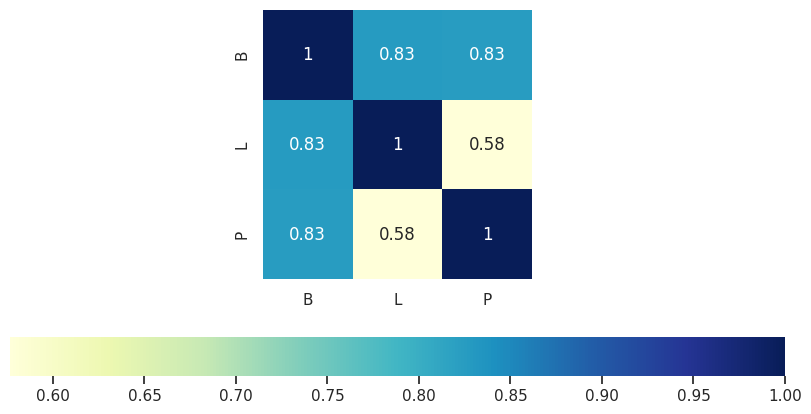

In [4]:
# correlações entre as variáveis
plt.figure(figsize=(10,5))
ax = sns.heatmap(dados.corr(),
                 annot=True,
                 cmap='YlGnBu',
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")

## ACP usando a matriz de correlações amostrais **R**

Obtenção dos componentes principais (usando *scikit-learn*)

In [5]:
X = dados

Aqui poderíamos usar a matriz R diretamente ou usar scale(X) que dá na mesma

In [6]:
# aplicar ACP usando a matriz de correlações
# usando um valor inteiro para a aleatorização permitindo a reprodutibilidade
pca = PCA(random_state=1)
resultado_pca = pca.fit_transform(scale(X))   # scale(X) padroniza os dados, como se usássemos a matriz R

In [7]:
resultado = pd.DataFrame({'cp1':resultado_pca[:, 0], 'cp2':resultado_pca[:, 1]}, index=X.index)

In [8]:
# coeficientes dos CPs (autovetores)
# cada linha é um CP
pca.components_

array([[ 0.62,  0.56,  0.56],
       [-0.  , -0.71,  0.71],
       [ 0.79, -0.44, -0.43]])

In [9]:
# variâncias dos CPs (autovalores)
pca.explained_variance_

array([2.72, 0.46, 0.09])

In [10]:
# as variâncias somadas devem dar um valor próximo de p = 3
pca.explained_variance_.sum()

np.float64(3.2727272727272703)

Então, os componentes principais a partir da matriz de correlações são:

\begin{align*}
  Y_1 = & + 0,62Z_1 + 0,56Z_2 + 0,56Z_3\\
  Y_2 = & - 0,00Z_1 - 0,71Z_2 + 0,71Z_3\\
  Y_3 = & + 0,79Z_1 - 0,44Z_2 - 0,43Z_3\\
\end{align*}

Sendo $Z_1$, $Z_2$ e $Z_3$ as versões padronizadas de $B$, $L$ e $P$.

Interpretação:

- Y1: índice de desempenho global da empresa (valores altos positivos indicam empresas que tiveram ganhos B, L e P maiores do que a média)
- Y2: comparação entre L e P (valores ~ 0 indicam empresas em que L está em equilíbrio com P)
- Y3: comparação de B com o índice composto por por L e P (representa pouco da variação total, mas pode ser de interesse para o pesquisador)

As variâncias dos componentes principais:

\begin{align*}
  V(Y_1) = 2,72\\
  V(Y_2) = 0,46\\
  V(Y_3) = 0,09\\
\end{align*}

In [11]:
# variância explicada acumulada
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 83.08,  97.2 , 100.  ])

In [12]:
X.columns

Index(['B', 'L', 'P'], dtype='object')

## Análise gráfica dos componentes

### Gráfico da variância acumulada

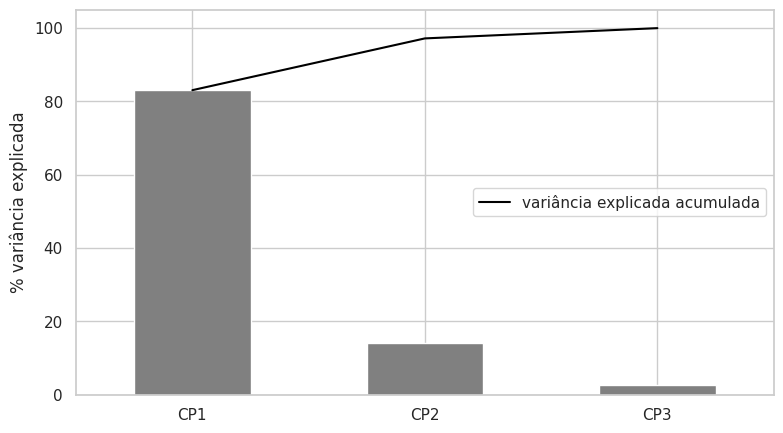

In [13]:
# variâncias acumuladas
tot = sum(pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
# número de CPs gerados (k = p)
cp =['CP'+str(i+1) for i in range(len(pca.components_))]
# dataframe com as variâncias acumuladas para criar o scree plot
df = pd.DataFrame({'cp': cp, 'var_exp': var_exp, 'cum_var_exp': cum_var_exp})
# scree plot com %
fig, ax = plt.subplots(figsize=(9,5))
df.plot.bar('cp', 'var_exp', color='gray', ax=ax, legend=False)
df.plot.line('cp', 'cum_var_exp', color='black', ax=ax)
plt.legend(labels=['variância explicada acumulada'],
           loc='center right',)
plt.ylabel('% variância explicada')
plt.xlabel('');

### *Scree plot*

O *Scree plot* é um gráfico com os autovalores de cada componente

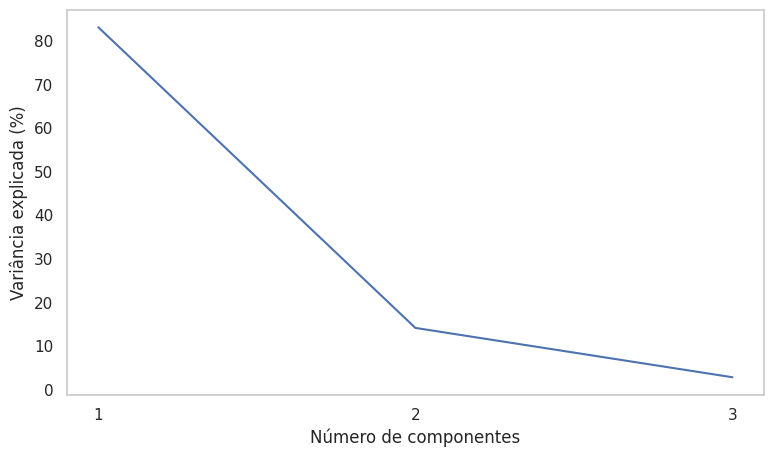

In [14]:
plt.figure(figsize=(9,5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_ * 100)
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada (%)')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid()
plt.show()

É possível ver pelo gráfico que o primeiro componente explica mais  de $80\%$ da variância dos dados.

### Efeito das variáveis em cada componente

O atributo 'components_' nos dá os autovetores que representam a direção de máxima variância dos dados.

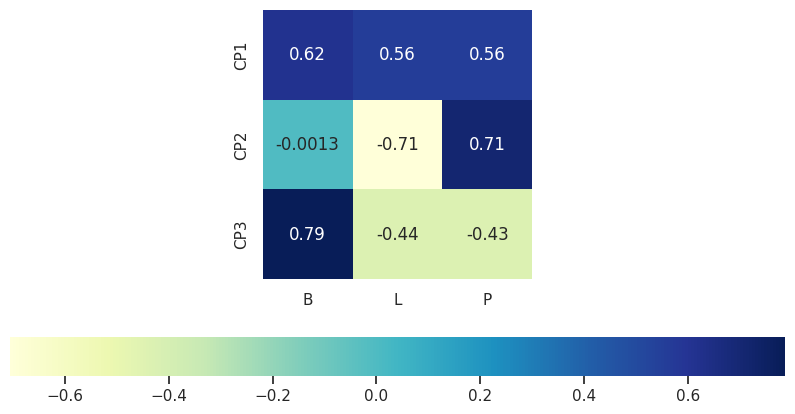

In [15]:
plt.figure(figsize=(10, 5))
ax = sns.heatmap(pca.components_,
                 annot=True,
                 cmap='YlGnBu',
                 yticklabels=[ "CP"+str(X) for X in range(1,pca.n_components_+1)],
                 xticklabels=list(X.columns),
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")

### ACP *Biplot*

*Biplot* é um gráfico interessante e contém muitas informações úteis.

Ele contém dois gráficos:

1. * Gráfico de dispersão do ACP * que mostra os dois primeiros componentes
2. * Gráfico de autovetores do ACP * que mostra a intensidade com que cada característica influencia um componente principal.

Os escores dos componentes principais estão nos eixos x e y e os comprimentos das setas representam os coeficientes de cada variável no CP correspondente.

**PCA Loading Plot:** Todos os vetores começam na origem e seus valores projetados nos componentes explicam quanto peso eles têm naquele componente. Além disso, os ângulos entre vetores individuais informam sobre a correlação entre eles.

Mais sobre o biplot [aqui] (http://www.nonlinear.com/support/progenesis/comet/faq/v2.0/pca.aspx)

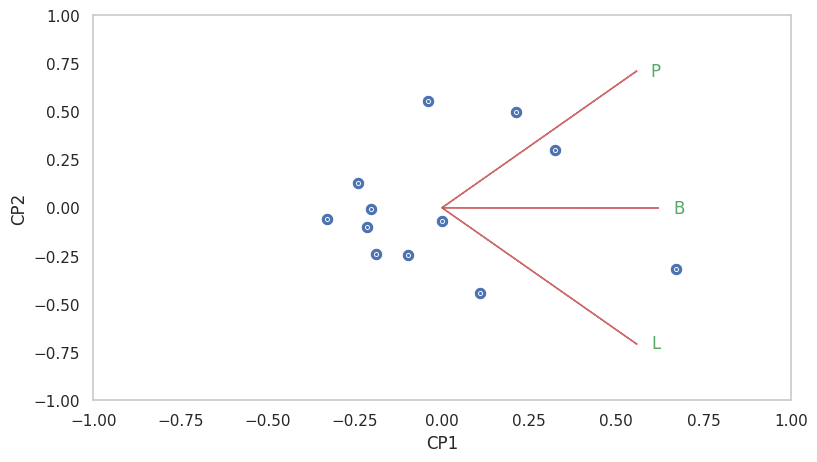

In [16]:
fig, ax = plt.subplots(figsize=(9,5))
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    xx = xs * scalex
    yy = ys * scaley
    plt.scatter(xx, yy, s=5, linewidths=6)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color='r', alpha=0.8)
        if labels is None:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1, "Var"+str(i+1), color='green', ha='center', va='center')
        else:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1, labels[i], color='g', ha='center', va='center')

    plt.xlabel("CP{}".format(1))
    plt.ylabel("CP{}".format(2))
    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    plt.grid()

myplot(resultado_pca[:,0:2],np.transpose(pca.components_[0:2, :]),list(X.columns))
plt.show()

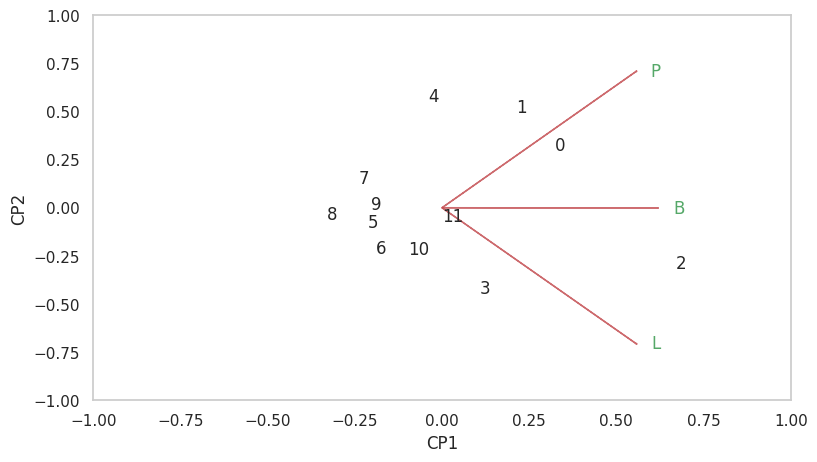

In [29]:
fig, ax = plt.subplots(figsize=(9,5))

def myplot(score, coeff, labels=None, point_labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    xx = xs * scalex
    yy = ys * scaley
    # plt.scatter(xx, yy, s=5, linewidths=6)

    if point_labels is not None:
        for i, txt in enumerate(point_labels):
            ax.annotate(txt, (xx[i], yy[i]))

    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color='r', alpha=0.8)
        if labels is None:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1, "Var"+str(i+1), color='green', ha='center', va='center')
        else:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1, labels[i], color='g', ha='center', va='center')

    plt.xlabel("CP{}".format(1))
    plt.ylabel("CP{}".format(2))
    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    plt.grid()

myplot(resultado_pca[:,0:2], np.transpose(pca.components_[0:2, :]), list(X.columns), point_labels=list(X.index))
plt.show()

#### Fazendo o *biplot* com a escala original dos escores

Isso pode dificultar um pouco a visualização das setas.

In [17]:
# fig, ax = plt.subplots(figsize=(9,5))
# def myplot_original(score,coeff,labels=None):
#     xs = score[:,0]
#     ys = score[:,1]
#     n = coeff.shape[0]
#     plt.scatter(xs, ys,s=5, linewidths = 6)
#     for i in range(n):
#         plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r',alpha = 0.8)
#         if labels is None:
#             plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
#         else:
#             plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1, labels[i], color = 'g', ha = 'center', va = 'center')

#     plt.xlabel("CP{}".format(1))
#     plt.ylabel("CP{}".format(2))
#     ax.set(xlim=(xs.min(), xs.max()), ylim=(ys.min(), ys.max()))
#     plt.grid()

# myplot_original(resultado_pca[:,0:2],np.transpose(pca.components_[0:2, :]),list(X.columns))
# plt.show()

#### Correlação entre CP e variáveis

A correlação entre $Y_j$ e $Z_i$ é dada por:
\begin{align*}
    r_{Y_j,Z_i} = a_{ji}\sqrt{\lambda_j}
\end{align*}

Por exemplo,

CP1 ($Y_1$):

- correlação entre $Y_1$ e $Z_1$ ($B$ padronizada): $r_{Y_1,Z_1} = a_{11}\sqrt{\lambda_1}$ =  $0,62\sqrt{2,72}$ = $1,00$

(a variável B padronizada é perfeitamente correlacionada com o primeiro componente principal, Y1).

- correlação entre $Y_1$ e $Z_2$ ($L$ padronizada): $r_{Y_1,Z_2} = a_{12}\sqrt{\lambda_1}$ =  $0,56\sqrt{2,72}$ = $0,92$

(a variável L padronizada é altamente correlacionada com o CP1, o Y1).

- correlação entre $Y_1$ e $Z_3$ ($P$ padronizada): $r_{Y_1,Z_3} = a_{13}\sqrt{\lambda_1}$ =  $0,56\sqrt{2,72}$ = $0,92$

(a variável P padronizada é altamente correlacionada com o CP1, o Y1).

CP2 ($Y_2$):

- correlação entre $Y_2$ e $Z_1$ ($B$ padronizada): $r_{Y_2,Z_1} = a_{21}\sqrt{\lambda_2}$ =  $0,00\sqrt{0,46}$ = $0$

(a variável B padronizada não é correlacionada com o CP2).

- correlação entre $Y_2$ e $Z_2$ ($L$ padronizada): $r_{Y_2,Z_2} = a_{22}\sqrt{\lambda_2}$ =  $-0,71\sqrt{0,46}$ = $-0,48$
(a variável L padronizada tem uma moderada correlação negativa com o CP2).

- correlação entre $Y_2$ e $Z_3$ ($P$ padronizada): $r_{Y_2,Z_3} = a_{23}\sqrt{\lambda_2}$ =  $0,71\sqrt{0,46}$ = $0,48$

(a variável P padronizada tem uma moderada correlação positiva com o CP2).

O mesmo seria feito para o CP3 ($Y_3$).

Cálculo das correlações entre os CPs e as variáveis:

In [18]:
print(pca.components_[0,:] * pca.explained_variance_[0] ** 0.5)
print(pca.components_[1,:] * pca.explained_variance_[1] ** 0.5)
print(pca.components_[2,:] * pca.explained_variance_[2] ** 0.5)

[1.02 0.92 0.92]
[-0.   -0.48  0.48]
[ 0.24 -0.13 -0.13]


#### Outra forma de fazer o *biplot*

Dessa forma estão os escores dos componentes principais nos eixos x e y e os comprimentos das setas representam as correlações entre os CPs e as variáveis ($r_{Y_j,Z_i}$).

A interpretação é muito parecida com o *biplot* apresentado antes (em que os tamanhos das setas representam os coeficientes de cada variável no CP correspondente).



In [19]:
features = X.columns
components = resultado_pca
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
fig = px.scatter(components, x=0, y=1)
# se houver alguma variável categórica colocar em color
# fig = px.scatter(components, x=0, y=1, color=df['species'])
for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()

Diagrama de dispersão dos dois primeiros componentes principais (sem padronização dos escores):

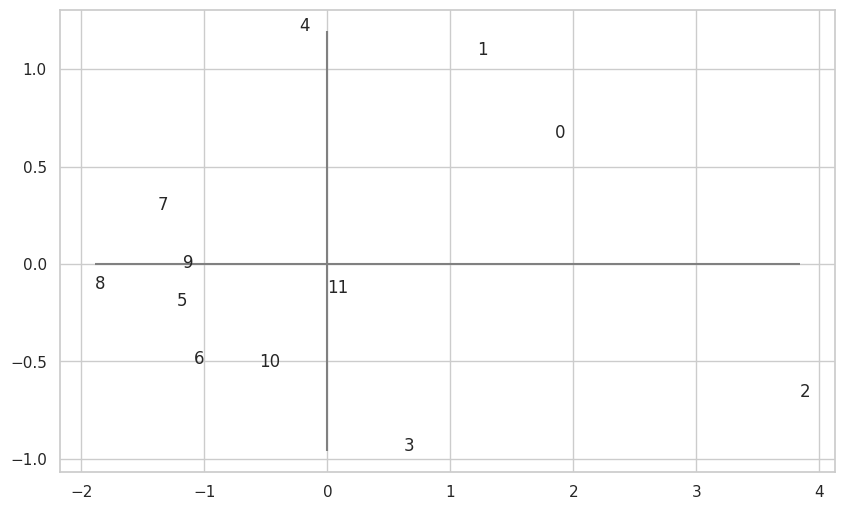

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.scatter(resultado.cp1, resultado.cp2, s=0)
for i, txt in enumerate(resultado.index):
    ax.annotate(txt, (resultado.cp1[i], resultado.cp2[i]))
plt.hlines(0, resultado_pca[:, 0].min(), resultado_pca[:, 0].max(), color='gray')
plt.vlines(0, resultado_pca[:, 1].min(), resultado_pca[:, 1].max(), color='gray');

Lembrando a interpretação ja realizada:

- Y1: índice de desempenho global da empresa (valores altos positivos indicam empresas que tiveram ganhos B, L e P maiores do que a média)
- Y2: comparação entre L e P (valores ~ 0 indicam empresas em que L está em equilíbrio com P)


Diagrama de dispersão dos dois primeiros componentes principais (com padronização dos escores):

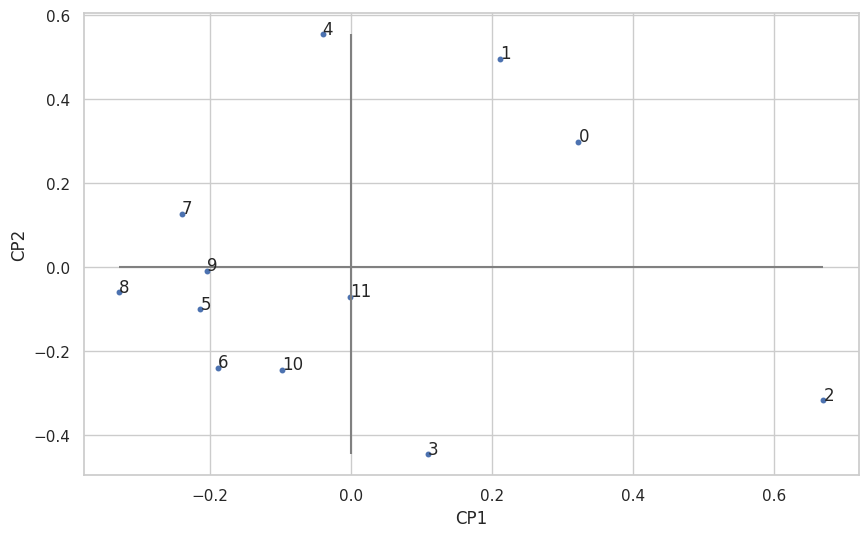

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
xs = resultado.iloc[:,0]
ys = resultado.iloc[:,1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
xx = xs*scalex
yy = ys*scaley
ax.scatter(xx, yy,s=5, linewidths=2)
plt.xlabel('CP1', fontsize=12)
plt.ylabel('CP2', fontsize=12)
for i, txt in enumerate(resultado.index):
    ax.annotate(txt, (xx[i], yy[i]))
plt.hlines(0, xx.min(), xx.max(), color='gray')
plt.vlines(0, yy.min(), yy.max(), color='gray');

A interpretação continua a mesma pois as observações continuam nos mesmos pontos.

Diagrama de dispersão de B x P (nos eixos) e L representado no tamanho das bolhas:

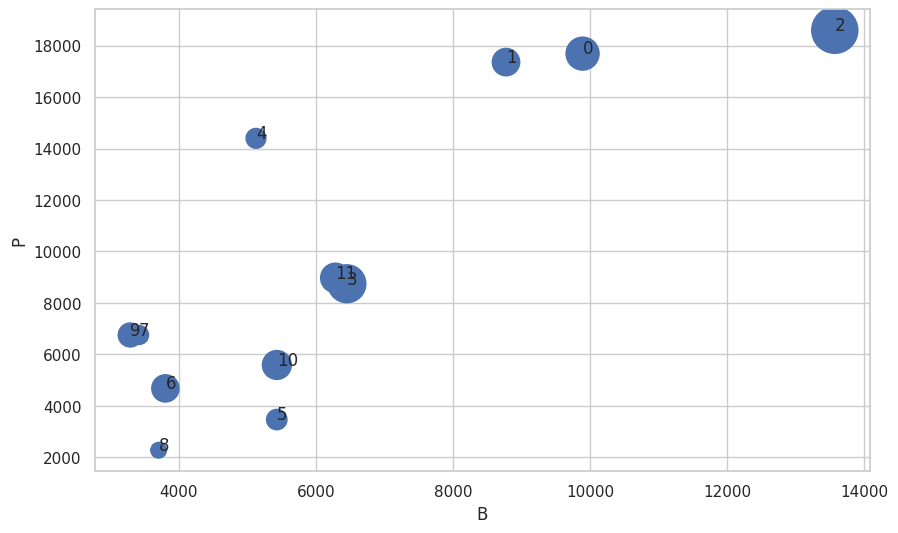

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.scatter(dados['B'], dados['P'], s=dados['L'])
for i, txt in enumerate(dados.index):
    ax.annotate(txt, (dados['B'][i], dados['P'][i]))
plt.xlabel("B")
plt.ylabel("P");

Diagrama de dispersão dos CPs em que o tamanho da bolha representa cada variável:

Tentativa de identificar como estão distribuídos os valores de cada variável.

In [23]:
# função para padronizar os valores das variáveis originais
def scale_sizes(sizes, min_size=1, max_size=1000):
    return ((sizes - np.min(sizes)) / (np.max(sizes) - np.min(sizes))) * (max_size - min_size) + min_size

Ganho bruto (B):

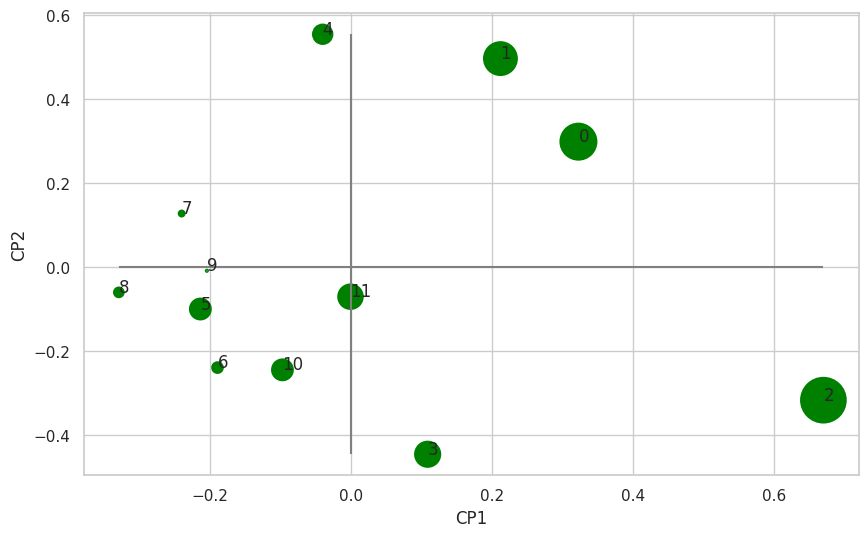

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
xs = resultado.iloc[:,0]
ys = resultado.iloc[:,1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
xx = xs*scalex
yy = ys*scaley
scaled_sizes = scale_sizes(dados['B'])
ax.scatter(xx, yy, s=scaled_sizes, linewidths=2, color='green')
plt.xlabel('CP1', fontsize=12)
plt.ylabel('CP2', fontsize=12)
for i, txt in enumerate(resultado.index):
    ax.annotate(txt, (xx[i], yy[i]))
plt.hlines(0, xx.min(), xx.max(), color='gray')
plt.vlines(0, yy.min(), yy.max(), color='gray');

Ganho líquido (L):

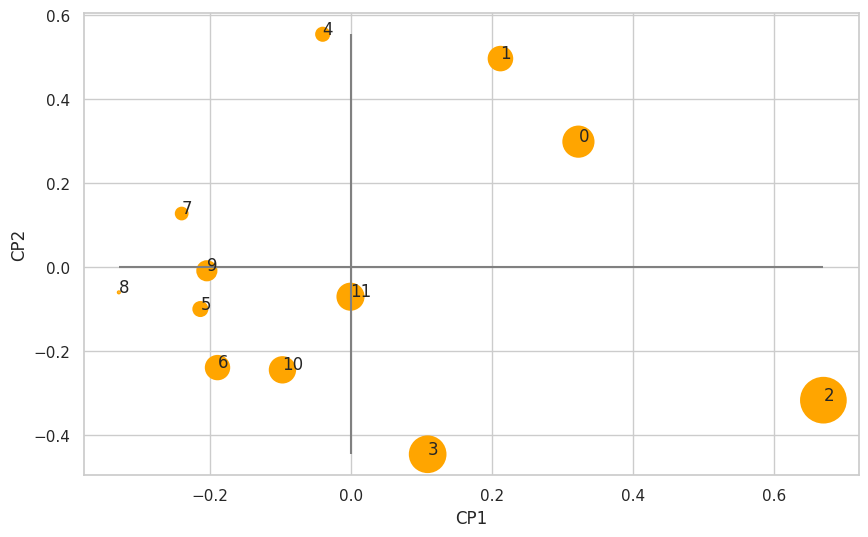

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
xs = resultado.iloc[:,0]
ys = resultado.iloc[:,1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
xx = xs*scalex
yy = ys*scaley
scaled_sizes = scale_sizes(dados['L'])
ax.scatter(xx, yy, s=scaled_sizes, linewidths=2, color='orange')
plt.xlabel('CP1', fontsize=12)
plt.ylabel('CP2', fontsize=12)
for i, txt in enumerate(resultado.index):
    ax.annotate(txt, (xx[i], yy[i]))
plt.hlines(0, xx.min(), xx.max(), color='gray')
plt.vlines(0, yy.min(), yy.max(), color='gray');

Patrimônio (P):

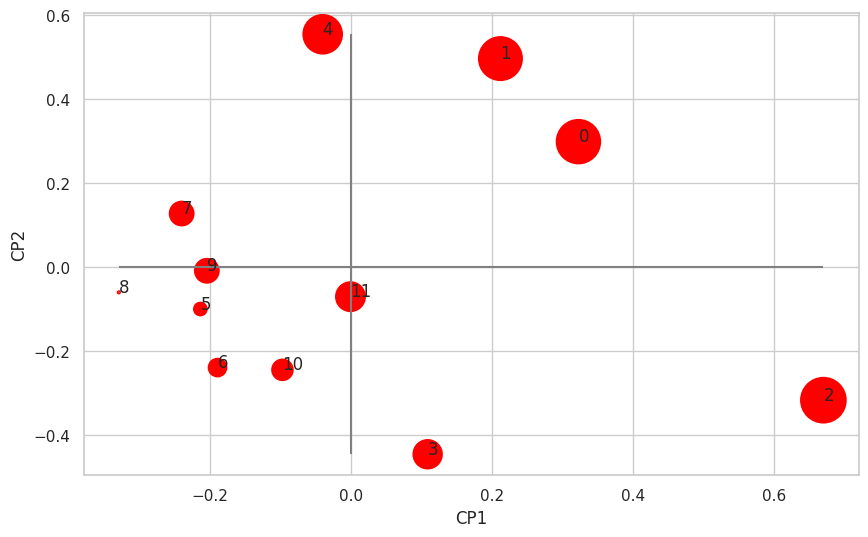

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
xs = resultado.iloc[:,0]
ys = resultado.iloc[:,1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
xx = xs*scalex
yy = ys*scaley
scaled_sizes = scale_sizes(dados['P'])
ax.scatter(xx, yy, s=scaled_sizes, linewidths=2, color='red')
plt.xlabel('CP1', fontsize=12)
plt.ylabel('CP2', fontsize=12)
for i, txt in enumerate(resultado.index):
    ax.annotate(txt, (xx[i], yy[i]))
plt.hlines(0, xx.min(), xx.max(), color='gray')
plt.vlines(0, yy.min(), yy.max(), color='gray');